In [ ]:
# 필요한 package loading
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Data generation
np.random.seed(seed=0)

time = np.arange(0, 1, 1/1000)
frequency = 20
sinewave = np.sin(2 * np.pi * frequency * time) # 사인 그래프 만들기
noise = np.random.normal(0,0.3,1000) # 사인 그래프에 더할 noise 만들기

data = sinewave + noise # 데이터 형성

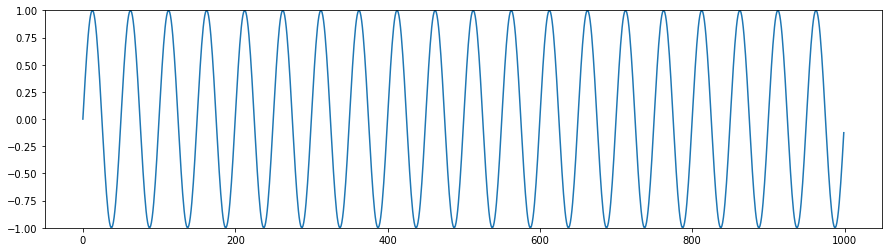

In [ ]:
# Visualize the generated data (sine)
plt.figure(figsize=(15,4))
plt.plot(sinewave)
plt.ylim(-1, 1)
plt.show()

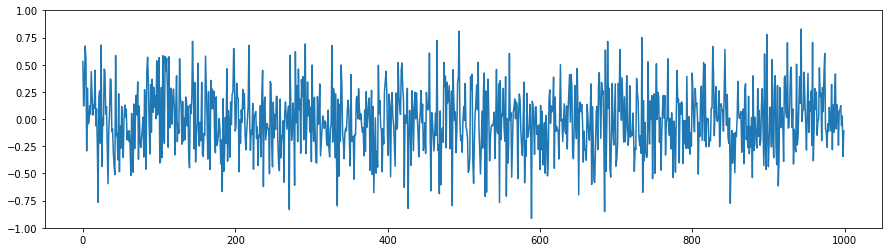

In [ ]:
# Visualize the generated data (noise)
plt.figure(figsize=(15,4))
plt.plot(noise)
plt.ylim(-1, 1)
plt.show()

In [ ]:
# Train and test data split

train_data = pd.DataFrame(data[0:500]) # 데이터의 반을 학습 데이터로 설정
train_data.columns = ['value']
train_data['label'] = 0
train_data.loc[160:189, 'value'] += 1.5 # 이상치 추가
train_data.loc[160:189, 'label'] = 1 # 이상치 라벨 달기

test_data = pd.DataFrame(data[500:]) # 데이터의 나머지 반을 시험 데이터로 설정
test_data.columns = ['value']
test_data['label'] = 0
test_data.loc[310:319, 'value'] += 1.5 # 이상치 추가
test_data.loc[450:459, 'value'] += 1.3
test_data.loc[310:319, 'label'] = 1 # 이상치 라벨 달기
test_data.loc[450:459, 'label'] = 1

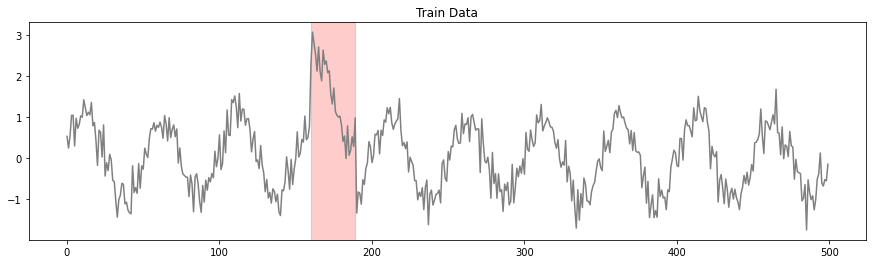

In [ ]:
# visualize the train dataset
fig = plt.figure(figsize=(15,4))
fig = plt.plot(train_data['value'],color='grey')
fig = plt.axvspan(160, 189, color='red', alpha=0.2) # 이상치 부분을 빨간 배경으로 표시
fig = plt.title('Train Data')
plt.show()

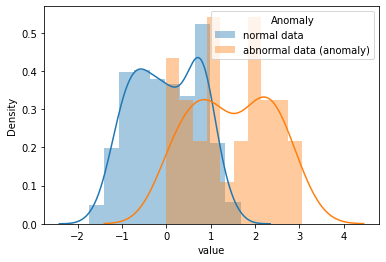

In [ ]:
# visualize the distributions of normal and abnormal data
sns.distplot(train_data['value'][train_data['label']==0], bins=10, label='normal data') # 정상 데이터 표시
sns.distplot(train_data['value'][train_data['label']==1], bins=10, label='abnormal data (anomaly)') # 이상 데이터 표시
plt.legend(title="Anomaly")
plt.show()

GMM model - parameter 설명: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

In [ ]:
# model train
# covariance types: full (each one has its own general covariance matrix), tied (all componenets share the same general covariance matrix), diag (diagnoal covariance matrix), spherical (single variance)

gm = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0) # 모델 선언
means = np.array([train_data['value'][train_data['label'] == i].mean(axis=0) for i in [0,1]]) # 훈련 데이터의 각 라벨 별 평균 구하기
gm.means_init = means.reshape(2,1) # 라벨 별 평균으로 모델 초기화 
gm.fit(np.array(train_data['value']).reshape(-1, 1)) # 학습 데이터로 모델 학습

GaussianMixture(means_init=array([[-0.00653296],
       [ 1.47557744]]),
                n_components=2, random_state=0)

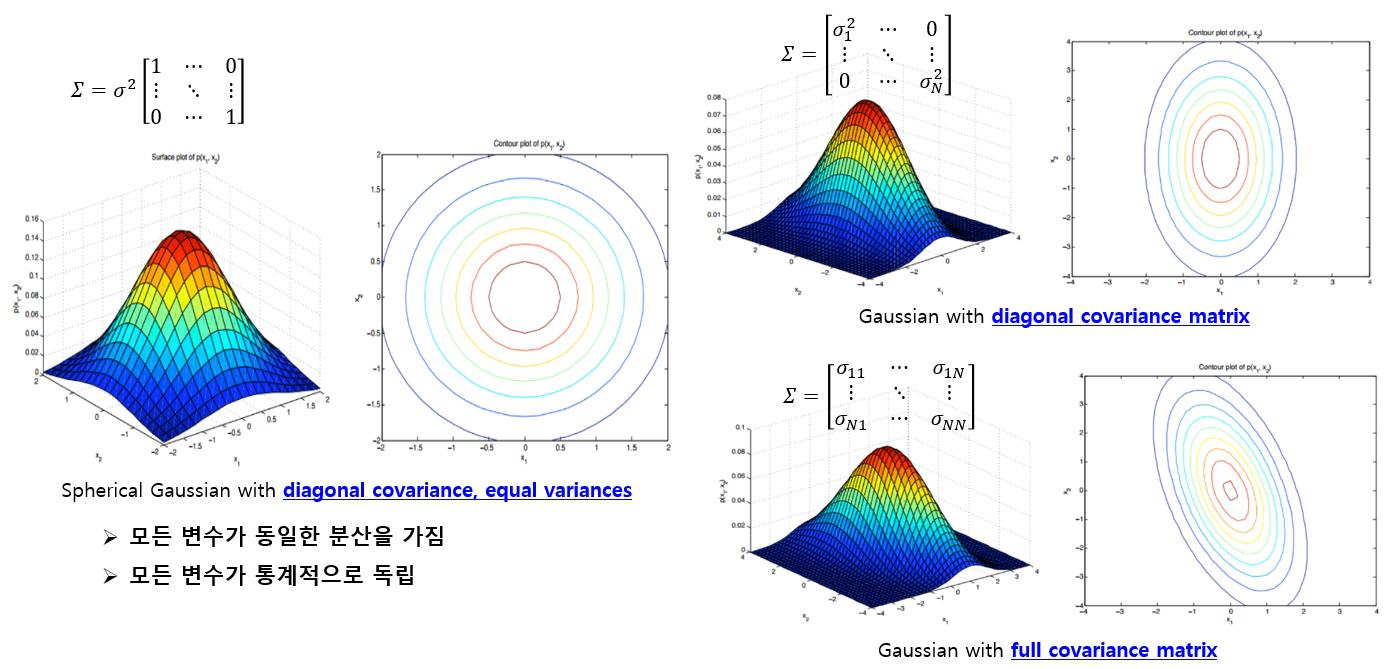

In [ ]:
# Anomaly probability for test data
anomaly_proba = gm.predict_proba(np.array(test_data['value']).reshape(-1, 1)) 

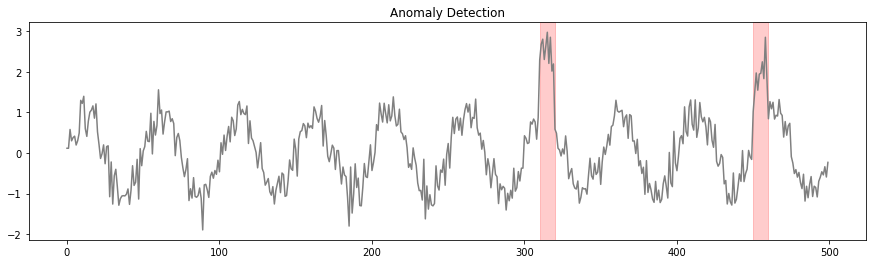

In [ ]:
# visualize the test data
fig = plt.figure(figsize=(15,4))
fig = plt.plot(test_data['value'],color='grey')
fig = plt.title('Anomaly Detection')
fig = plt.axvspan(310, 320, color='red', alpha=0.2) # 이상치 영역: 빨간색
fig = plt.axvspan(450, 460, color='red', alpha=0.2)
plt.show()

In [ ]:
# Threshold에 따른 성능 평가
results = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1-score']) # 테스트 결과 데이터 프레임 만들기
for i in np.arange(0.1, 1, 0.1): # threshold 0.1부터 0.9까지 0.1 간격으로 반복문
    anomaly_predict = (anomaly_proba[:, 1]>i) # 이상 확률이 threshold를 넘는 값을 이상치로 식별 
    scores = classification_report(test_data['label'], anomaly_predict, target_names = ['normal', 'anomaly'], output_dict=True) # 모델 성능 평가하기
    print(scores)
    result = str(np.round(i,1)), scores['macro avg']['precision'], scores['macro avg']['recall'], scores['macro avg']['f1-score'] # threshold, precision, recall, f1-score를 저장
    results = results.append(pd.Series(result, index=results.columns), ignore_index=True) # 테스트 결과 데이터 프레임에 추가
results = results.set_index('threshold') # threshold를 테스트 결과 데이터 프레임의 인덱스로 설정

{'normal': {'precision': 1.0, 'recall': 0.5041666666666667, 'f1-score': 0.6703601108033241, 'support': 480}, 'anomaly': {'precision': 0.07751937984496124, 'recall': 1.0, 'f1-score': 0.14388489208633096, 'support': 20}, 'accuracy': 0.524, 'macro avg': {'precision': 0.5387596899224806, 'recall': 0.7520833333333333, 'f1-score': 0.40712250144482753, 'support': 500}, 'weighted avg': {'precision': 0.9631007751937984, 'recall': 0.524, 'f1-score': 0.6493011020546444, 'support': 500}}
{'normal': {'precision': 1.0, 'recall': 0.61875, 'f1-score': 0.7644787644787645, 'support': 480}, 'anomaly': {'precision': 0.09852216748768473, 'recall': 1.0, 'f1-score': 0.17937219730941703, 'support': 20}, 'accuracy': 0.634, 'macro avg': {'precision': 0.5492610837438424, 'recall': 0.809375, 'f1-score': 0.47192548089409075, 'support': 500}, 'weighted avg': {'precision': 0.9639408866995074, 'recall': 0.634, 'f1-score': 0.7410745017919905, 'support': 500}}
{'normal': {'precision': 1.0, 'recall': 0.7145833333333333,

In [ ]:
results

,precision,recall,f1-score
threshold,,,
0.1,0.538760,0.752083,0.407123
0.2,0.549261,0.809375,0.471925
0.3,0.563694,0.857292,0.529762
0.4,0.578740,0.888542,0.573335
0.5,0.607527,0.923958,0.635841
0.6,0.671604,0.937500,0.733333
0.7,0.795807,0.961458,0.858001
0.8,0.973958,0.973958,0.973958
0.9,0.994845,0.875000,0.925981


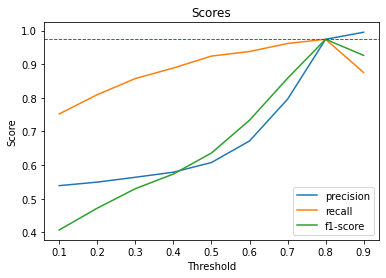

In [ ]:
# visualize the metrics according to the threshold
plt.title('Scores')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.plot(results['precision'], label='precision')
plt.plot(results['recall'], label='recall')
plt.plot(results['f1-score'], label='f1-score')
plt.axhline(float(results['f1-score'].max()), lw=0.9, ls='--', color='green') # f1-score가 가장 높은 경우를 점선으로 표시
plt.legend()
plt.show()

In [ ]:
# indexing the anomalies
float(results['f1-score'].idxmax()) # threshold가 0.8일 때 f1-score 최대치를 가짐 
anomaly_index = (anomaly_proba[:,1] > float(results['f1-score'].idxmax())).nonzero()
anomaly_index

(array([ 60, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 451, 452,
        453, 454, 455, 456, 457, 458, 459]),)

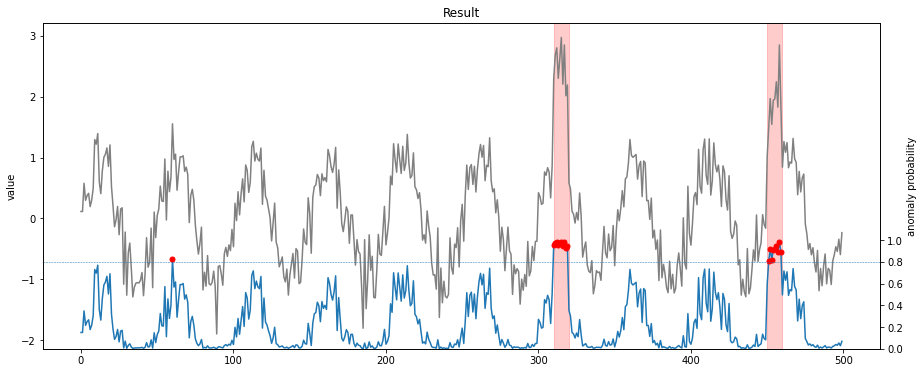

In [ ]:
# visualize the anomalies
fig, ax1 = plt.subplots(figsize=(15,6)) 
ax1.plot(test_data['value'],color='grey')
ax1.set_ylabel('value')
ax1.set_title('Result')
ax1.axvspan(310, 320, color='red', alpha=0.2) # 이상치가 있는 위치를 빨간 배경으로 표시
ax1.axvspan(450, 460, color='red', alpha=0.2)

ax2 = ax1.twinx() # 이상 확률을 표시하기 위한 plot 
ax2.plot(anomaly_proba[:,1]) # 이상 확률 표시
ax2.plot(anomaly_index, [anomaly_proba[i][:] for i in anomaly_index][0][:, 1].reshape(1,20), ls="", marker="o", color='red', markersize=5) # 예측된 이상치를 점으로 표시
ax2.set_ylim(0,3)
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax2.set_ylabel('anomaly probability') 
ax2.axhline(y=float(results['f1-score'].idxmax()), ls='--', lw=0.5) # f1-score가 최대인 경우의 threshold를 가로선으로 표시
                                                                    # 이상 확률이 가로선을 넘는 경우 모델이 이상치로 판단
plt.show()